<a href="https://colab.research.google.com/github/rajalingam24/Emotion-Detection/blob/main/Approch_3EmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing necessary libraries

import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing datasets

dataset_path = '/content/drive/MyDrive/Colab file/fer2013.csv'

df = pd.read_csv(dataset_path)

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

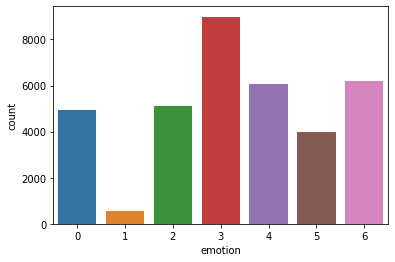

In [ ]:
import seaborn as sns
sns.countplot(data=df, x = 'emotion')
plt.show()

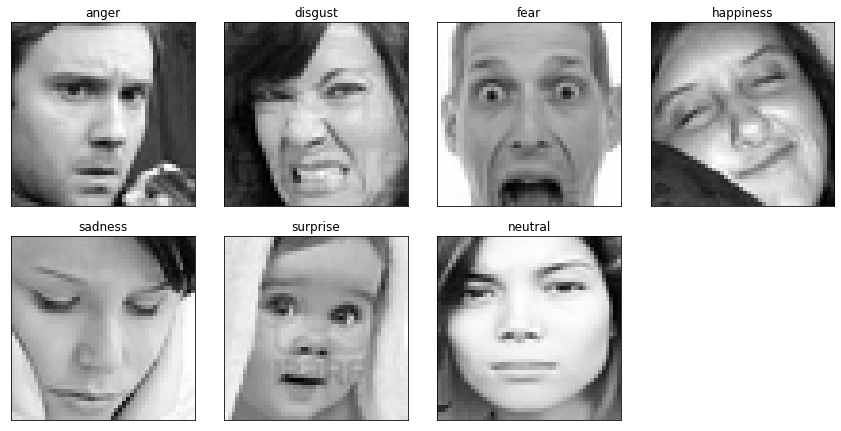

In [ ]:
# Visualizing the datasets

emotions_dummy = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

fig = plt.figure(1, (12, 12))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(1):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(4, 4, k)
        ax.imshow(px , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions_dummy[label])
        plt.tight_layout()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
image_size=(48,48)

# Data Loading and Pre-Processing Functionalities

def load_dataset():
    data = pd.read_csv(dataset_path)
    data = (data[data['pixels'].notnull()])
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = (data['emotion'])#.values
    return faces, emotions
 
def preprocess_data(x):
    x = x.astype('float32')
    x = x / 255.0
    return x
 
#Data Augumentation
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


In [ ]:
faces, emotions = load_dataset()
faces = preprocess_data(faces)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [ ]:
# Neural Network Definition

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5,5), input_shape = (Xtrain.shape[1:]), padding='same'))
model.add(Conv2D(64, kernel_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(filters=128, kernel_size=(5,5), padding='same'))
model.add(Conv2D(128, kernel_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(Conv2D(256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(7, activation='softmax'))

optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
activation (Activation)      (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
batch_size = 128
num_epochs = 10
from tensorflow.keras.utils import to_categorical

history = model.fit(Xtrain, to_categorical(Ytrain), 
                    batch_size = batch_size, 
                    epochs = num_epochs, 
                    
                    validation_data= (Xtest, to_categorical(Ytest)))

Epoch 1/10
225/225 [==============================] - 48s 70ms/step - loss: 1.6319 - accuracy: 0.3820 - val_loss: 1.8886 - val_accuracy: 0.3405
Epoch 2/10
225/225 [==============================] - 15s 66ms/step - loss: 1.2962 - accuracy: 0.5090 - val_loss: 1.5325 - val_accuracy: 0.4377
Epoch 3/10
225/225 [==============================] - 15s 66ms/step - loss: 1.1399 - accuracy: 0.5699 - val_loss: 1.2962 - val_accuracy: 0.5170
Epoch 4/10
225/225 [==============================] - 15s 67ms/step - loss: 1.0348 - accuracy: 0.6108 - val_loss: 1.1733 - val_accuracy: 0.5708
Epoch 5/10
225/225 [==============================] - 15s 67ms/step - loss: 0.9433 - accuracy: 0.6511 - val_loss: 1.1934 - val_accuracy: 0.5639
Epoch 6/10
225/225 [==============================] - 15s 68ms/step - loss: 0.8549 - accuracy: 0.6874 - val_loss: 1.2178 - val_accuracy: 0.5602
Epoch 7/10
225/225 [==============================] - 15s 68ms/step - loss: 0.7527 - accuracy: 0.7261 - val_loss: 1.3388 - val_accuracy:

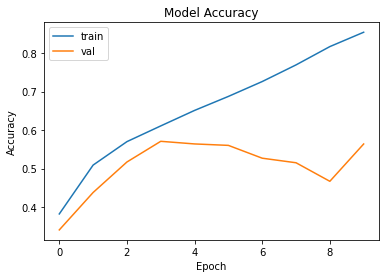

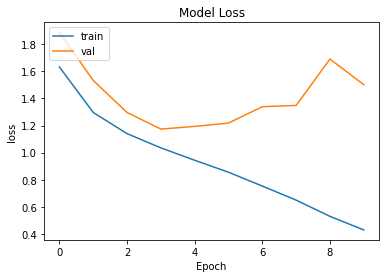

In [ ]:
# Plotting Performance Metrics


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


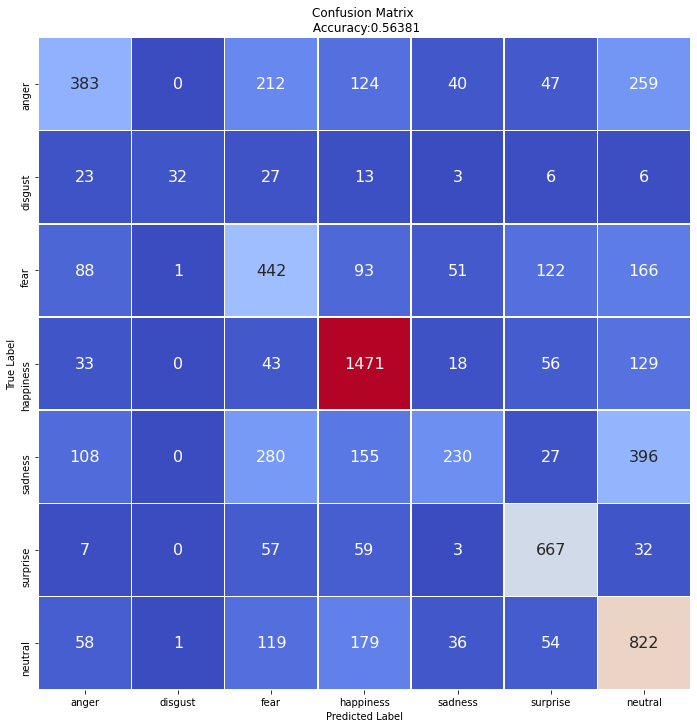

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

Ypred = model.predict_classes(Xtest)
y_test = to_categorical(Ytest).argmax(axis=-1)

cm = confusion_matrix(y_test, Ypred) 
LABELS = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
cm_df = pd.DataFrame(cm, index = LABELS, columns = LABELS)

plt.figure(figsize=(12,12))
sns.heatmap(cm_df, annot=True, fmt="d", linewidths=0.5, cmap='coolwarm', cbar=False, annot_kws={'size':16}, square=True)
plt.title('Confusion Matrix \n Accuracy:{0:.5f}'.format(accuracy_score(y_test, Ypred)))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()